In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style('darkgrid')

In [27]:
data_dir = Path('../data/ml-100k')


ratings = pd.read_csv(data_dir / 'u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


In [28]:
movies = pd.read_csv(data_dir/'u.item', sep='|', encoding='ISO-8859-1', names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 
    'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 
    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 
    'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

movies.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [29]:
users = pd.read_csv(data_dir/'u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
users.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [30]:
data = pd.merge(ratings, users, on='user_id')
data = pd.merge(data, movies[['movie_id', 'movie_title']], on='movie_id')

data.head()

,user_id,movie_id,rating,timestamp,age,gender,occupation,zip_code,movie_title
0,196,242,3,1997-12-04 15:55:49,49,M,writer,55105,Kolya (1996)
1,186,302,3,1998-04-04 19:22:22,39,F,executive,00000,L.A. Confidential (1997)
2,22,377,1,1997-11-07 07:18:36,25,M,writer,40206,Heavyweights (1994)
3,244,51,2,1997-11-27 05:02:03,28,M,technician,80525,Legends of the Fall (1994)
4,166,346,1,1998-02-02 05:33:16,47,M,educator,55113,Jackie Brown (1997)


In [31]:
from surprise import  Dataset, Reader, SVD, accuracy
from surprise.model_selection import  train_test_split, cross_validate

reader = Reader()
dataset = Dataset.load_from_df(data[['user_id', 'movie_id', 'rating']], reader)

trainset, testset = train_test_split(dataset, test_size=0.2)

# Learn SVD
model = SVD(n_epochs=30)
model.fit(trainset)

# Score on test
predictions = model.test(testset)

# RMSE
accuracy.rmse(predictions)


RMSE: 0.9425


0.9425364824581646

In [32]:
def get_recommendations(user_id, model, data, num_recommendations=5):
    # Watched movie list for user
    watched = data[data['user_id'] == user_id]['movie_id'].tolist()

    # Marking all movies in stock and show what movies haven't watched by user 
    all_movies = data['movie_id'].unique()
    movies_predict = [movie for movie in all_movies if movie not in watched]

    # Rating predict for movies
    predictions = [model.predict(user_id, movie_id) for movie_id in movies_predict]

    # Sorting by rating
    top_recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)[:num_recommendations]
    
    for recommendation in top_recommendations:
        movie_title = movies[movies['movie_id'] == recommendation.iid]['movie_title'].values[0]
        print(f"Movie: {movie_title}, Predicted Rating: {recommendation.est:.2f}")

# Example for user 1
get_recommendations(user_id=1, model=model, data=data)


Movie: L.A. Confidential (1997), Predicted Rating: 5.00
Movie: Schindler's List (1993), Predicted Rating: 5.00
Movie: Singin' in the Rain (1952), Predicted Rating: 5.00
Movie: Third Man, The (1949), Predicted Rating: 4.97
Movie: Paths of Glory (1957), Predicted Rating: 4.95


In [33]:
users['age_bin'] = pd.qcut(users['age'], 4)
users['age_bin'] = pd.cut(users['age'], 
                bins=[0,25,30,45,np.inf], 
                labels=['<= 25', '26 - 30', '31 - 45', '>= 45'])

users.head()

,user_id,age,gender,occupation,zip_code,age_bin
0,1,24,M,technician,85711,<= 25
1,2,53,F,other,94043,>= 45
2,3,23,M,writer,32067,<= 25
3,4,24,M,technician,43537,<= 25
4,5,33,F,other,15213,31 - 45


In [34]:
ratings['liked'] = np.where(ratings['rating'] >=3, 1, 0)
ratings

,user_id,movie_id,rating,timestamp,liked
0,196,242,3,1997-12-04 15:55:49,1
1,186,302,3,1998-04-04 19:22:22,1
2,22,377,1,1997-11-07 07:18:36,0
3,244,51,2,1997-11-27 05:02:03,0
4,166,346,1,1998-02-02 05:33:16,0
...,...,...,...,...,...
99995,880,476,3,1997-11-22 05:10:44,1
99996,716,204,5,1997-11-17 19:39:03,1
99997,276,1090,1,1997-09-20 22:49:55,0
99998,13,225,2,1997-12-17 22:52:36,0


In [35]:
users.head()

,user_id,age,gender,occupation,zip_code,age_bin
0,1,24,M,technician,85711,<= 25
1,2,53,F,other,94043,>= 45
2,3,23,M,writer,32067,<= 25
3,4,24,M,technician,43537,<= 25
4,5,33,F,other,15213,31 - 45


In [36]:
# Onehot for user and drop age, zip code

users = pd.get_dummies(users.drop(columns = ['age','zip_code']))
users_features_col = users.drop(columns =['user_id']).columns.values
users_feat = users.drop(columns =['user_id']).to_dict(orient='records')

users.head()

,user_id,gender_F,gender_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,...,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer,age_bin_<= 25,age_bin_26 - 30,age_bin_31 - 45,age_bin_>= 45
0,1,False,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,False
1,2,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,3,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,False
3,4,False,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,False
4,5,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [37]:
# Use only genre in 'movies'
movies_features = movies.drop(columns=['movie_title', 'release_date', 'video_release_date', 'IMDb_URL'])

movies_features

,movie_id,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,1679,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1679,1680,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1680,1681,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
from lightfm.data import Dataset

dataset = Dataset()

dataset.fit(users=users['user_id'].values, items=movies['movie_id'].values,
            item_features=movies_features.columns.values, user_features=users.drop(columns=['user_id']).columns.values)


num_users, num_movies = dataset.interactions_shape()
print(f'Num users: {num_users}, num_movies: {num_movies}')


Num users: 943, num_movies: 1682


In [39]:
item_features = dataset.build_item_features((x, y) for x, y in zip(movies['movie_id'], movies_features.to_dict(orient='records')))
user_features = dataset.build_user_features((x, y) for x, y in zip(users['user_id'], users.drop(columns=['user_id']).to_dict(orient='records')))

In [40]:
(interactions, weights) = dataset.build_interactions((x, y) for x, y in zip(ratings['user_id'], ratings['movie_id']))

In [41]:
from lightfm.cross_validation import random_train_test_split

train, test = random_train_test_split(interactions,test_percentage=0.2, random_state=42)

train_w, test_w = random_train_test_split(weights, test_percentage=0.2, random_state=42)

In [43]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

n_components = 30
loss = 'warp'
epoch = 40
num_thread = 4
model = LightFM(no_components= n_components, loss=loss, random_state = 42)
model.fit(train,  user_features= user_features, item_features= item_features, epochs=epoch,num_threads = num_thread, sample_weight = train_w)

train_precision = precision_at_k(model, train, k=10,item_features=item_features, user_features=user_features).mean()
test_precision = precision_at_k(model, test,train_interactions=train, k=10,item_features=item_features, user_features=user_features).mean()

train_recall = recall_at_k(model, train, k=10,item_features=item_features, user_features=user_features).mean()
test_recall = recall_at_k(model, test,train_interactions=train, k=10,item_features=item_features, user_features=user_features).mean()

train_auc = auc_score(model, train,item_features=item_features, user_features=user_features).mean()
test_auc = auc_score(model, test, train_interactions=train,item_features=item_features, user_features=user_features).mean()

print('Precision: train %.2f' % (train_precision))
print('Precision: test %.2f' % (test_precision))

print('Recall: train %.2f' % (train_recall))
print('Recall: test %.2f' % (test_recall))

print('AUC: train %.2f' % (train_auc))
print('AUC: test %.2f' % (test_auc))

Precision: train 0.41
Precision: test 0.19
Recall: train 0.07
Recall: test 0.10
AUC: train 0.84
AUC: test 0.85


In [ ]:
ratings['liked'].value_counts()


liked
1    82520
0    17480
Name: count, dtype: int64

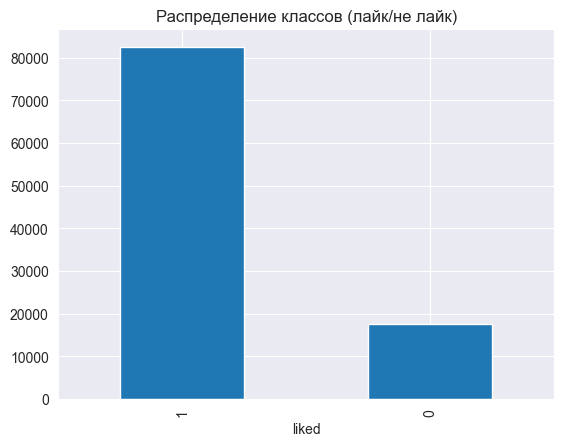

In [ ]:
ratings['liked'].value_counts().plot(kind='bar')
plt.title('Распределение классов (лайк/не лайк)')
plt.show()
